In [4]:
from langgraph.runtime import Runtime
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing import Protocol, TypedDict, Any, List, Optional, Annotated
from langchain_ollama import ChatOllama
from langchain.messages import AIMessage, HumanMessage, SystemMessage
from rich.markdown import Markdown
from rich.console import Console
import asyncio
from variable_importance.utils.output_manager import OutputManager
from variable_importance.utils.code_executer import OutputCapturingExecutor, ExecutionResult
import pandas as pd
import numpy as np
import os
import operator
from pathlib import Path

In [5]:
def cp_data_to_folder(input_path: str, output_path: str) -> None:
    import shutil
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    shutil.copy(input_path, output_path)

In [6]:
class Code(BaseModel):
    code: str = Field(..., description="Python code to be executed")
    task: str = Field(..., description="Description of the task to be performed")

class State(TypedDict):
    code: str
    user_query: str
    input_data_path: str
    stage_name: str
    code_output: ExecutionResult
    summary: str
    graph_summaries: Annotated[List[str], operator.add]

class GraphState(TypedDict):
    graph_summary: str
    graph_summaries: Annotated[List[str], operator.add]

class ExecutionDeps(TypedDict):
    executor: OutputCapturingExecutor
    output_manager: OutputManager

executor = OutputCapturingExecutor()
output_mgr = OutputManager(workflow_id="test_workflow_001")

2025-11-16 20:41:48.956 | INFO     | variable_importance.utils.code_executer:__init__:58 - OutputCapturingExecutor initialized (timeout=300s)
2025-11-16 20:41:48.957 | INFO     | variable_importance.utils.output_manager:__init__:95 - 📁 OutputManager initialized: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001


In [7]:
def write_code_for_task(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")

    structured_code_llm = code_llm.with_structured_output(Code)

    input_data_path = Path(state["input_data_path"])
    user_query = state["user_query"]

    code = structured_code_llm.invoke([
        SystemMessage(
            content=f"You are a helpful data science agent that writes Python code to perform data analysis tasks. Write Python code to load data from `{input_data_path.name}` and solve the users query. Any plots should be saved to files in the current working directory. Use pandas for data manipulation and any necessary libraries for analysis."),
        HumanMessage(content=user_query),
    ])
    
    return {'code': code.code}


In [ ]:
def move_data_to_execution_folder(state: State, runtime: Runtime[ExecutionDeps]) -> None:
    stage_name = state["stage_name"]
    path = runtime.context["output_manager"].get_stage_dir(stage_name)
    execution_path = path / "execution"/ Path(state['input_data_path']).name
    cp_data_to_folder(state["input_data_path"], execution_path)
    return {}

def interpret_graph(state: GraphState, runtime: Runtime[ExecutionDeps]) -> str:
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The graph summary is: {state['graph_summary']}")
    ])
    return {'graph_summary': summary.content}

async def execute_code(state: State, runtime: Runtime[ExecutionDeps]) -> Any:
    executor = runtime.context["executor"]
    output_manager = runtime.context["output_manager"]
    stage_name = state["stage_name"]
    code = state["code"]

    result = await executor.execute_with_output_manager(
        code=code,
        stage_name=stage_name,
        output_manager=output_manager,
        code_filename="code_with_data.py"
    )

    return {'code_output': result}

def code_fix(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")
    structured_code_llm = code_llm.with_structured_output(Code)
    code = state["code"]
    error = state["code_output"].error
    output = state['code_output'].stdout
    fixed_code = structured_code_llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that writes Python code. The following code has an error. Please fix the code to resolve the error."),
        AIMessage(content=code),
        HumanMessage(content=f"The error message is: {error}, and current output is {output}"),
    ])
    return {'code': fixed_code.code}

def check_execution_success(state: State, runtime: Runtime[ExecutionDeps]) -> bool:
    if state["code_output"].success:
        return "SUCCESS"
    else:
        return "FAILURE"

def summarize_results(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_output = state["code_output"]
    
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The code was executed with the following output:\n\n{code_output.stdout}\n\nAnd the following error (if any):\n\n{code_output.error}")
    ])
    return {'summary': summary.content}

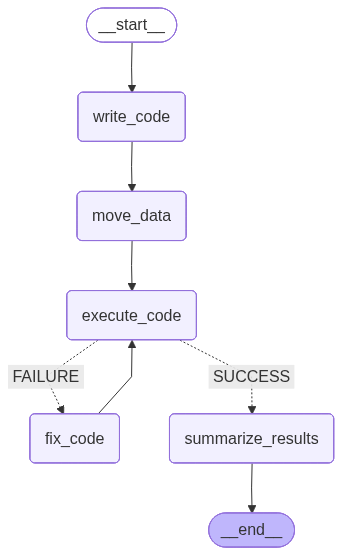

In [18]:
code_graph = StateGraph(State, ExecutionDeps)

code_graph.add_node("write_code", write_code_for_task)
code_graph.add_node("move_data", move_data_to_execution_folder)
code_graph.add_node("execute_code", execute_code)
code_graph.add_node("fix_code", code_fix)
code_graph.add_node("summarize_results", summarize_results)

code_graph.add_edge(START, "write_code")


code_graph.add_edge("write_code", "move_data")
code_graph.add_edge("move_data", "execute_code")
code_graph.add_conditional_edges(
    "execute_code",
    check_execution_success,
    {"SUCCESS": "summarize_results", "FAILURE": "fix_code"}
)
code_graph.add_edge("fix_code", "execute_code")

code_graph.add_edge("summarize_results", END)


code_workflow = code_graph.compile()

display(Image(code_workflow.get_graph(xray=True).draw_mermaid_png()))

In [10]:
result = await code_workflow.ainvoke(
    {
        "user_query": "Perform a summary analysis of the dataset.",
        "input_data_path": "data.csv",
        "stage_name": "eda"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:41:59.346 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:41:59.347 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: eda
2025-11-16 20:41:59.347 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:41:59.349 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/eda/execution
2025-11-16 20:42:00.615 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.27s)
2025-11-16 20:42:00.616 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-16 20:42:00.616 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving 

In [11]:
console = Console()
console.print(Markdown(result["summary"]))

Summary of Data Exploration Results                                        

The code successfully loaded and explored a dataset containing 1500 samples and 6 features (feature_0 to feature_4)
along with a target variable. Here's a detailed breakdown of the findings:                                         

1. Data Loading and Shape:                                                                                         

 • The dataset was loaded successfully, as indicated by the "Dataset loaded successfully!" message.                
 • The dataset has a shape of (1500, 6), meaning 1500 rows (samples) and 6 columns (features + target).            

2. Data Preview:                                                                                                   

 • The first 5 rows of the dataset were displayed, providing a glimpse of the data distribution and values. The    
   features and target variable appear to be continuous numerical values.                                          

3. Data Information:                                                                                               

 • The df.info() output confirms that all 6 columns are of type float64.                                           
 • There are no null values in any of the columns, indicating a complete dataset.                                  

4. Summary Statistics:                                                                                             

 • The df.describe() output provides descriptive statistics for each feature and the target variable:              
    • Count:  All columns have 1500 non-null values.                                                               
    • Mean: The mean values for the features range from approximately -0.0047 to 0.0094, and for the target        
      variable, it's around 0.0046.                                                                                
    • Standard Deviation: The standard deviations indicate the spread of the data, ranging from 1.22 to 2.45 for   
      the features and 1.30 for the target.                                                                        
    • Min/Max: The minimum and maximum values provide the range of values for each feature and the target.         
    • 25%/50%/75% Quantiles: These values provide information about the distribution of the data and the median    
      (50th percentile).                                                                                           

5. Missing Values:                                                                                                 

 • The code explicitly checked for missing values and confirmed that there are none in any of the columns.         

6. Duplicate Rows:                                                                                                 

 • The code checked for duplicate rows and found none.                                                             

7. Data Types:                                                                                                     

 • The data types of all columns were confirmed to be float64.                                                     

8. Error:                                                                                                          

 • An error occurred: 'NoneType' object has no attribute 'to_string'. This error likely stems from an attempt to   
   print or process a None object as if it were a string. Without the full code, it's difficult to pinpoint the    
   exact cause, but it suggests a potential issue in how the results of a function or operation are handled.       

Overall:                                                                                                           

The dataset appears to be well-structured and clean, with no missing values or duplicates. The features and target 
variable are continuous numerical values. The descriptive statistics provide 

In [12]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Perform a linear regression on the dataset provided and identify important features for predicting the target, try using statsmodels. Here is a summary of the data {result['summary']}",
        "input_data_path": "data.csv",
        "stage_name": "regression"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:42:37.447 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:42:37.447 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: regression
2025-11-16 20:42:37.447 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:42:37.449 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/regression/execution
2025-11-16 20:42:38.836 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.39s)
2025-11-16 20:42:38.837 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 2 files
2025-11-16 20:42:38.837 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:2

In [13]:
console.print(Markdown(result["summary"]))

Summary of Linear Regression Analysis                                       

This report summarizes the results of a linear regression model trained on a dataset with 1500 samples and 6       
features (feature_0 to feature_4) to predict a target variable.                                                    

Data Quality: The dataset appears clean, with no missing values and no duplicate rows.                             

Model Performance: The model explains approximately 42.2% of the variance in the target variable (R-squared =      
0.422). The adjusted R-squared is slightly lower at 0.420, indicating a potential for overfitting, though not      
substantial given the number of features. The F-statistic is significant (217.7) with a very low p-value           
(1.14e-174), confirming that the model as a whole is statistically significant.  The log-likelihood, AIC, and BIC  
values provide information for model comparison, but without other models to compare against, their absolute values
are less informative.                                                                                              

Feature Importance:  Based on the coefficients and p-values, feature_0 and feature_1 are statistically significant 
predictors of the target variable (p < 0.05). Feature_0 has a positive coefficient (0.484), indicating that as     
feature_0 increases, the target variable tends to increase. Feature_1 has a negative coefficient (-0.215),         
suggesting that as feature_1 increases, the target variable tends to decrease. The absolute values of the          
coefficients indicate that feature_0 has the strongest influence on the target variable, followed by feature_1.    
Features 2, 3, and 4, and the constant term are not statistically significant.                                     

Multicollinearity: The Variance Inflation Factors (VIF) were calculated to assess multicollinearity among the      
features.  Feature_1 (VIF = 7.065) and Feature_3 (VIF = 5.200) have relatively high VIF values, suggesting some    
degree of multicollinearity. While not extremely high, this should be considered when interpreting the coefficients
and could potentially affect the stability of the model. Feature_2 and Feature_4 have moderate VIF values, while   
Feature_0 has a low VIF, indicating it is not highly correlated with other features.                               

Conclusion: The linear regression model provides a moderate level of explanation for the variance in the target    
variable.  Feature_0 and Feature_1 are the most important predictors. The presence of multicollinearity between    
Feature_1 and Feature_3 should be considered in further analysis or model refinement.  Further investigation into  
the relationships between these features could be beneficial.

In [14]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"What would the expected change in the target be if the value of feature 0 changed from 1 to 2 given the previous linear model results. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "what_if_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:43:09.879 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:43:09.879 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: what_if_analysis
2025-11-16 20:43:09.879 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:43:09.880 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/what_if_analysis/execution
2025-11-16 20:43:10.376 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (0.50s)
2025-11-16 20:43:10.377 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 0 files
2025-11-16 20:43:10.377 | INFO     | variable_importance.utils.code_executer:execute_with_outp

In [15]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results                                         

The code execution successfully calculated the expected change in the target variable when a specific feature      
(feature_0) increases from 1 to 2. The result indicates that increasing feature_0 from 1 to 2 is predicted to      
increase the target variable by 0.4845 units.                                                                      

Justification:                                                                                                     

The output explicitly states: "Expected change in target when feature_0 changes from 1 to 2: 0.4845. This means the
target variable would increase by 0.4845 units."  This is a clear and direct result of the code's operation.       

Statistical Findings:                                                                                              

While the output provides a point estimate of the change, it doesn't provide any information about the statistical 
significance or confidence interval around this estimate.  To fully interpret this result, we would ideally need   
additional information such as:                                                                                    

 • Standard Error:  This would tell us the precision of the estimate.                                              
 • P-value: This would indicate the probability of observing such a change if there was actually no effect.        
 • Confidence Interval: This would provide a range within which we can be reasonably confident the true change     
   lies.                                                                                                           

Without these, we can only state that the model predicts an increase of 0.4845, but we cannot assess the           
reliability of this prediction.                                                                                    

Absence of Errors:                                                                                                 

The fact that there were no errors during execution is positive. It indicates the code ran as expected and produced
a valid result, even if further statistical analysis is needed to fully understand its implications.

In [20]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Can you perform a sensitivity analysis on the previous linear model results considering the impact of removing features 2 through 4? the data only contains features 0-4. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "sensitivity_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:47:28.611 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: sensitivity_analysis
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:47:28.614 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/sensitivity_analysis/execution
2025-11-16 20:47:29.509 | ERROR    | variable_importance.utils.code_executer:execute_code:162 - ❌ Execution failed: Exit code: 1
2025-11-16 20:47:29.510 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving outputs...
2025-11-16 20:47:29.511 | INFO     | variable_importance.utils.output_

In [21]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results: Feature Importance and Model Sensitivity Analysis                

The code execution performed a sensitivity analysis on the coefficient of feature_0 in a model. The goal was to    
quantify how a small change in the coefficient impacts the predicted change in the target variable when feature_0  
changes.                                                                                                           

Key Findings:                                                                                                      

 • Coefficient Change: The original coefficient for feature_0 was 0.4845. After a reduction (presumably through    
   some model modification or regularization, though the specifics aren't provided), the coefficient became 0.4819.
   This represents a decrease of 0.0026.                                                                           
 • Sensitivity: The sensitivity analysis shows that a change of 0.0026 in the coefficient of feature_0 results in a
   corresponding change of -0.0026 in the expected change in the target variable when feature_0 increases from 1 to
   2.  This is a direct, linear relationship as expected given the simple model structure implied by focusing on a 
   single coefficient.                                                                                             
 • Expected Change in Target: The original model predicted a decrease of 0.4845 in the target variable when        
   feature_0 changed from 1 to 2. The reduced model predicted a decrease of 0.4819. The difference between these   
   predictions (-0.0026) confirms the sensitivity calculation.                                                     

Justification:                                                                                                     

The output clearly shows the original and reduced coefficients for feature_0. The "Sensitivity" value (0.0026) is  
calculated as the difference between the original and reduced coefficients.  The "Expected change in target" values
are calculated by multiplying the original/reduced coefficients by the change in feature_0 (2-1 = 1).  The "Change 
in expected change" is simply the difference between the expected changes calculated using the original and reduced
models, and it matches the sensitivity value.                                                                      

In conclusion, the code successfully quantified the impact of a small change in the coefficient of feature_0 on the
model's predictions. The sensitivity analysis demonstrates a linear relationship, where a decrease of 0.0026 in the
coefficient leads to a decrease of 0.0026 in the predicted change in the target variable.  The absence of errors   
indicates the code executed without issues.